# Text Summarization

#### Importing libraries/modules

In [0]:
import os
import re
import string
import numpy as np
import matplotlib.pyplot as plt
from nltk import pos_tag
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus.reader.wordnet import NOUN, VERB, ADJ, ADV
from nltk.corpus import brown, stopwords
from nltk.cluster.util import cosine_distance
from operator import itemgetter
%matplotlib inline

In [0]:
import nltk
nltk.download('brown')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Text Cleaner Class

In [0]:
class TextCleaner():
    
    def __init__(self):
        self.stop_words = set(stopwords.words("english"))
        self.punctuations = set(string.punctuation)
        self.pos_tags = {
                NOUN: ['NN', 'NNS', 'NNP', 'NNPS', 'PRP', 'PRP$', 'WP', 'WP$'],
                VERB: ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
                ADJ: ['JJ', 'JJR', 'JJS'],
                ADV: ['RB', 'RBR', 'RBS', 'WRB']
        }


    def _remove_stop_words(self, words):
        return [word for word in words if word not in self.stop_words]
     
    
    def _remove_regex(self):
        self.input_sent = " ".join([w.lower() for w in self.input_sent])
        self.input_sent = re.sub(r"i'm", "i am", self.input_sent)
        self.input_sent = re.sub(r"he's", "he is", self.input_sent)
        self.input_sent = re.sub(r"she's", "she is", self.input_sent)
        self.input_sent = re.sub(r"that's", "that is", self.input_sent)
        self.input_sent = re.sub(r"what's", "what is", self.input_sent)
        self.input_sent = re.sub(r"where's", "where is", self.input_sent)
        self.input_sent = re.sub(r"\'ll", " will", self.input_sent)
        self.input_sent = re.sub(r"\'ve", " have", self.input_sent)
        self.input_sent = re.sub(r"\'re", " are", self.input_sent)
        self.input_sent = re.sub(r"\'d", " would", self.input_sent)
        self.input_sent = re.sub(r"won't", "will not", self.input_sent)
        self.input_sent = re.sub(r"can't", "cannot", self.input_sent)
        self.input_sent = re.sub(r"don't", "do not", self.input_sent)
        patterns = re.finditer("#[\w]*", self.input_sent)
        for pattern in patterns:
            self.input_sent = re.sub(pattern.group().strip(), "", self.input_sent)
        self.input_sent = "".join(ch for ch in self.input_sent if ch not in self.punctuations)
    
    
    def _tokenize(self):
        return word_tokenize(self.input_sent)
    
    
    def _process_content_for_pos(self, words):
        tagged_words = pos_tag(words)
        pos_words = []
        for word in tagged_words:
            flag = False
            for key, value in self.pos_tags.items():
                if word[1] in value:
                    pos_words.append((word[0], key))
                    flag = True
                    break
            if not flag:
                pos_words.append((word[0], NOUN))
        return pos_words
       
                 
    def _remove_noise(self):
        self._remove_regex()
        words = self._tokenize()
        noise_free_words = self._remove_stop_words(words)
        return noise_free_words
    
    
    def _normalize_text(self, words):
        lem = WordNetLemmatizer()
        pos_words = self._process_content_for_pos(words)
        normalized_words = [lem.lemmatize(w, pos=p) for w, p in pos_words]
        return normalized_words
    
    
    def clean_up(self, input_sent):
        self.input_sent = input_sent
        cleaned_words = self._remove_noise()
        cleaned_words = self._normalize_text(cleaned_words)
        return cleaned_words

### Cosine similarity among sentences

In [0]:
def sentence_similarity(sent1, sent2):
    text_cleaner = TextCleaner()
  
    sent1 = text_cleaner.clean_up(sent1)
    sent2 = text_cleaner.clean_up(sent2)
    
    all_words = list(set(sent1 + sent2))
    
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
    
    for w in sent1:
        vector1[all_words.index(w)] += 1
    
    for w in sent2:
        vector2[all_words.index(w)] += 1
    
    return 1 - cosine_distance(vector1, vector2)

### Similarity Adjacency Matrix for PageRank

In [0]:
def build_similarity_matrix(sentences):
    S = np.zeros((len(sentences), len(sentences)))
    for i in range(len(sentences)):
        for j in range(i + 1, len(sentences)):
            if i == j:
                continue
            else:
                S[i][j] = sentence_similarity(sentences[i], sentences[j])
                S[j][i] = S[i][j]   
    for i in range(len(S)):
        S[i] /= S[i].sum()
    return S

## PageRank Algorithm

In [0]:
def pagerank(M, eps=1.0e-4, d=0.85):
    n = len(M)
    probs = np.ones(n) / n
    for i in range(100):
        new_p = np.ones(n) * (1 - d) / n + d * M.T.dot(probs)
        delta = abs(new_p - probs).sum()
        if delta <= eps:
            break
        probs = new_p
    return new_p   

#### Preprocessing of data

In [0]:
def preprocess(file_content):
  sents_in_content = sent_tokenize(file_content)
  sents = []
  for sent in sents_in_content:
    sent = sent.split("\n\n")
    for s in sent:
      if s != "":
        sents.append(s)
  sentences = []
  for sent in sents:
    sentences.append(word_tokenize(sent))
  return sentences

#### Summarizing based on TextRank and PageRank algorithms

In [0]:
def summarize(sentences, SUMMARY_SIZE):
  S = build_similarity_matrix(sentences)
  sentence_ranks = pagerank(S)
  
  # If summary size not entered
  if SUMMARY_SIZE == 0:
    average_rank = np.average(sentence_ranks)
    above_average_ranks = 0
    for rank in sentence_ranks:
      if rank > 1.2 * average_rank:
        above_average_ranks+=1
    if len(sentences) / 5 > above_average_ranks:
      SUMMARY_SIZE = len(sentences) / 5
    else:
      SUMMARY_SIZE = above_average_ranks

  ranked_sentence_indexes = [item[0] for item in sorted(enumerate(sentence_ranks), key=lambda item: -item[1])]
  selected_sentences = sorted(ranked_sentence_indexes[:SUMMARY_SIZE])
  summary = itemgetter(*selected_sentences)(sentences)
  return summary

#### Generate Summary

In [0]:
def process_summary(summary):
  my_summary = ""
  for sentence in summary:
    for word in sentence:
      if word != "":
        if word == "." or word == "," or word == "'s" or word == "$" or word == "%":
          my_summary = my_summary[:-1]
        my_summary = my_summary + word + " "
  return my_summary

### Input article

In [0]:
# test_string = input()
choice = int(input("Choice of summary: \n1) General summary \n2) Custom length summary \n"))
if choice == 1:
  SUMMARY_SIZE = 0
elif choice == 2:
  SUMMARY_SIZE = int(input("Enter summary size: "))
else:
  print("Invalid choice")

sentences = preprocess(content)
# sentences = brown.sents('ca01')
summary = summarize(sentences, SUMMARY_SIZE)
my_summary = process_summary(summary)
print(my_summary)

Choice of summary: 
1) General summary 
2) Custom length summary 
2
Enter summary size: 7
The Fulton County Grand Jury said Friday an investigation of Atlanta's recent primary election produced `` no evidence '' that any irregularities took place. The jury further said in term-end presentments that the City Executive Committee, which had over-all charge of the election, `` deserves the praise and thanks of the City of Atlanta '' for the manner in which the election was conducted. `` Only a relative handful of such reports was received '', the jury said, `` considering the widespread interest in the election, the number of voters and the size of this city ''. The grand jury commented on a number of other topics, among them the Atlanta and Fulton County purchasing departments which it said `` are well operated and follow generally accepted practices which inure to the best interest of both governments ''. `` This is one of the major items in the Fulton County general assistance program '

In [0]:
S = build_similarity_matrix(sentences)

In [0]:
S

array([[0.        , 0.03809933, 0.03196713, ..., 0.01191345, 0.01459093,
        0.        ],
       [0.04793482, 0.        , 0.01714968, ..., 0.01278262, 0.01565545,
        0.        ],
       [0.07569435, 0.03227618, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.02576081, 0.02196889, 0.        , ..., 0.        , 0.08413444,
        0.        ],
       [0.03354197, 0.02860469, 0.        , ..., 0.08944524, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [0]:
sentence_ranks = pagerank(S)

**Sentences ranked according to their importance**

In [0]:
sentence_ranks

array([0.0234675 , 0.0187665 , 0.01123576, 0.01796357, 0.01644115,
       0.00846616, 0.01785976, 0.00216536, 0.01290006, 0.01462607,
       0.00543299, 0.01058538, 0.0066213 , 0.01317727, 0.02275843,
       0.01325513, 0.01805431, 0.00624031, 0.00954899, 0.00265891,
       0.01534067, 0.01430723, 0.01044828, 0.00642507, 0.00498534,
       0.01078784, 0.00911497, 0.00516437, 0.01049278, 0.01266148,
       0.01151728, 0.00534986, 0.00529231, 0.00266882, 0.01216652,
       0.00934046, 0.00409488, 0.01335719, 0.00465669, 0.00869262,
       0.00770543, 0.00903736, 0.00670723, 0.01026237, 0.01186828,
       0.01089543, 0.00584541, 0.01092386, 0.00698091, 0.00923407,
       0.016825  , 0.01488211, 0.0070233 , 0.01099078, 0.00457551,
       0.00265688, 0.00641047, 0.00982585, 0.00844966, 0.00710591,
       0.00937989, 0.00634396, 0.01179258, 0.0094353 , 0.01636128,
       0.00659305, 0.01444638, 0.01100428, 0.01211079, 0.01313992,
       0.01311141, 0.01551948, 0.00834415, 0.00715822, 0.00902

In [0]:
ranked_sentence_indexes = [item[0] for item in sorted(enumerate(sentence_ranks), key=lambda item: -item[1])]

In [0]:
ranked_sentence_indexes

[0,
 14,
 1,
 16,
 3,
 6,
 50,
 4,
 64,
 93,
 86,
 71,
 20,
 51,
 77,
 9,
 66,
 21,
 80,
 37,
 76,
 15,
 13,
 69,
 70,
 8,
 82,
 29,
 34,
 68,
 92,
 44,
 62,
 95,
 30,
 2,
 67,
 53,
 75,
 47,
 45,
 25,
 96,
 84,
 11,
 28,
 22,
 43,
 88,
 97,
 94,
 57,
 18,
 63,
 60,
 35,
 49,
 89,
 26,
 41,
 74,
 78,
 39,
 5,
 58,
 72,
 83,
 91,
 40,
 79,
 73,
 59,
 52,
 48,
 42,
 12,
 65,
 23,
 56,
 61,
 17,
 46,
 10,
 31,
 32,
 27,
 24,
 85,
 38,
 54,
 36,
 87,
 90,
 33,
 19,
 55,
 81,
 7]

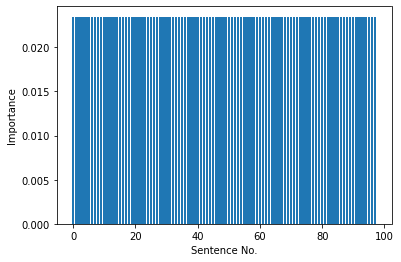

In [0]:
plt.bar([item[0] for item in sorted(enumerate(sentence_ranks))], sentence_ranks.T[0])
plt.xlabel("Sentence No.")
plt.ylabel("Importance")
plt.show()

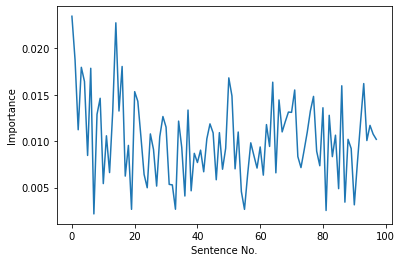

In [0]:
plt.plot([item[0] for item in sorted(enumerate(sentence_ranks))], sentence_ranks)
plt.xlabel("Sentence No.")
plt.ylabel("Importance")
plt.show()

In [0]:
selected_sentences = sorted(ranked_sentence_indexes[:SUMMARY_SIZE]) 

In [0]:
selected_sentences

[0, 1, 3, 6, 14, 16, 50]

In [0]:
summary = itemgetter(*selected_sentences)(sentences)

#### Translation support

In [0]:
pip install googletrans

  Created wheel for googletrans: filename=googletrans-2.4.0-cp36-none-any.whl size=15777 sha256=fb7f631d3e43ca517f720a0fdeb0c3d1bcb66843e96feef60b68c641524e108c
  Stored in directory: /root/.cache/pip/wheels/50/d6/e7/a8efd5f2427d5eb258070048718fa56ee5ac57fd6f53505f95
Successfully built googletrans


In [0]:
import googletrans

print("What language is your article in?")
print(googletrans.LANGUAGES)
source_language = input() # de

What language is your article in?
{'af': 'afrikaans', 'sq': 'albanian', 'am': 'amharic', 'ar': 'arabic', 'hy': 'armenian', 'az': 'azerbaijani', 'eu': 'basque', 'be': 'belarusian', 'bn': 'bengali', 'bs': 'bosnian', 'bg': 'bulgarian', 'ca': 'catalan', 'ceb': 'cebuano', 'ny': 'chichewa', 'zh-cn': 'chinese (simplified)', 'zh-tw': 'chinese (traditional)', 'co': 'corsican', 'hr': 'croatian', 'cs': 'czech', 'da': 'danish', 'nl': 'dutch', 'en': 'english', 'eo': 'esperanto', 'et': 'estonian', 'tl': 'filipino', 'fi': 'finnish', 'fr': 'french', 'fy': 'frisian', 'gl': 'galician', 'ka': 'georgian', 'de': 'german', 'el': 'greek', 'gu': 'gujarati', 'ht': 'haitian creole', 'ha': 'hausa', 'haw': 'hawaiian', 'iw': 'hebrew', 'hi': 'hindi', 'hmn': 'hmong', 'hu': 'hungarian', 'is': 'icelandic', 'ig': 'igbo', 'id': 'indonesian', 'ga': 'irish', 'it': 'italian', 'ja': 'japanese', 'jw': 'javanese', 'kn': 'kannada', 'kk': 'kazakh', 'km': 'khmer', 'ko': 'korean', 'ku': 'kurdish (kurmanji)', 'ky': 'kyrgyz', 'lo':

In [0]:
from googletrans import Translator
translator = Translator()

test_string = input() # 'Die Kessiner waren ein elb­slawi­scher Stamm, der vom 10. bis zum 12. Jahr­hun­dert im öst­lichen Teil des heuti­gen Mecklen­burg an­sässig war. Sie waren ur­sprüng­lich ein Kern­stamm der Lutizen und zähl­ten ab den 1060er Jahren zum abodriti­schen Stammes­ver­band. Wahr­schein­lich ent­stand der Stamm um das Jahr 1000 als Ab­spal­tung von den Zirzi­panen. Anläss­lich ihrer ersten schrift­lichen Erwäh­nung als Chizzini zum Jahr 1057 werden die Kessi­ner als Mit­glied des Lutizen­bundes ge­nannt. Kurze Zeit später fügte der abodriti­sche Samt­herr­scher Gott­schalk die Kessiner gewalt­sam in den abodriti­schen Stammes­ver­band ein, dem sie trotz an­dauern­der Auto­nomie­bestre­bun­gen bis zu dessen Ein­gliede­rung in das Heilige Römi­sche Reich ange­hörten. Die For­schung befasst sich vor­rangig mit der Ein­gren­zung ihres Siedlungs­gebie­tes und der auf­fallend späten Stammesbildung.'
content_in_english = translator.translate(test_string, src=source_language, dest='en')

SUMMARY_SIZE = int(input("Enter summary size: "))

content = content_in_english.text
sentences = preprocess(content)
summary = summarize(sentences, SUMMARY_SIZE)
english_summary = process_summary(summary)
print(english_summary)

source_language_summary = translator.translate(english_summary, src='en', dest=source_language)
my_summary = source_language_summary.text
print(my_summary)

Enter summary size: 6
The Kessin were a elbslawischer strain which was located between the 10th and 12th century in the eastern part of today's Mecklenburg. They were originally a tribe of nuclear Lutizen and counted from the 1060s years to abodritischen tribal confederation. Probably the base by the year 1000 emerged as a splinter group from the Circipania. On the occasion of its first written mention as Chizzini the year 1057 the Kessin be named as a member of Lutizenbundes. A short time later, the abodritische Samtherrscher Gottschalk added the Kessin force in the tribal confederation abodritischen one, which they belonged despite ongoing autonomy until its incorporation into the Holy Roman Empire. The research is primarily concerned with the limitation of their settlement area and the striking late tribal education. 
Die Kessin waren ein elbslawischer Stamm, der zwischen dem 10. und 12. Jahrhundert im östlichen Teil des heutigen Mecklenburg befand. Sie waren ursprünglich ein Stamm 

#### Dataset

In [0]:
!mkdir -p Dataset
%cd Dataset

/content/Dataset/Dataset


In [0]:
# For CNN/DailyMail dataset
!wget https://raw.githubusercontent.com/janvig/TextSummarizer/master/CNN_DailyMail.zip

# For news article dataset
# !wget https://raw.githubusercontent.com/janvig/TextSummarizer/master/NewsArticleDataset.zip

--2020-06-07 16:46:05--  https://raw.githubusercontent.com/janvig/TextSummarizer/master/CNN_DailyMail.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39443702 (38M) [application/zip]
Saving to: ‘CNN_DailyMail.zip’

CNN_DailyMail.zip   100%[===================>]  37.62M  89.4MB/s    in 0.4s    

2020-06-07 16:46:06 (89.4 MB/s) - ‘CNN_DailyMail.zip’ saved [39443702/39443702]



In [0]:
import zipfile

# For CNN/DailyMail dataset
zip_ref = zipfile.ZipFile("./CNN_DailyMail.zip", 'r')

# For news article dataset
# zip_ref = zipfile.ZipFile("./NewsArticleDataset.zip", 'r')

zip_ref.extractall("./")
zip_ref.close()

##### Fetching human summaries from dataset

In [0]:
summaries = []
labels = []

# For CNN/DailyMail dataset
directory = "/content/Dataset/test_output/reference"

# For news article dataset 
# directory = "/content/Dataset/Summary"

# files = os.listdir(directory)
for i in range(1000):
  f_name = f'{i:06}'
  fName = f_name + "_reference.txt"
  path = directory + "/" + fName
  # path = directory + "/" + files[i]
  f = open(path, "r")
  content = f.read()
  # If source language is not English
  # summary_in_english = translator.translate(content, src=source_language, dest='en')
  # content = summary_in_english.text
  summaries.append(content)
  labels.append(fName)
  # labels.append(files[i])
# summaries, labels

##### Fetching content (articles in dataset) -> Preprocessing data -> Summarizing

In [0]:
my_summaries = []
my_labels = []

# For CNN/DailyMail dataset
directory = "/content/Dataset/test_output/articles"

# For news article dataset 
# directory = "/content/Dataset/News article"

# files = os.listdir(directory)
SUMMARY_SIZE = 5 
for i in range(1000):
  f_name = f'{i:06}'
  fName = f_name + "_article.txt"
  path = directory + "/" + fName
  # path = directory + "/" + files[i]
  if i % 50 == 0:
    print("Processing : ", i )
  f = open(path, "r")
  content = f.read()
  # If source language is not English
  # content_in_english = translator.translate(content, src=source_language, dest='en')
  # content = content_in_english.text
  sentences = preprocess(content)
  summary = summarize(sentences, SUMMARY_SIZE)
  my_summary = process_summary(summary)
  my_summaries.append(my_summary)
  my_labels.append(fName)
  # my_labels.append(files[i])
# my_summaries, my_labels 

Processing :  0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/nltk/cluster/util.py:133: RuntimeWarning: invalid value encountered in true_divide
  sqrt(numpy.dot(u, u)) * sqrt(numpy.dot(v, v))))


Processing :  50
Processing :  100
Processing :  150
Processing :  200
Processing :  250
Processing :  300
Processing :  350
Processing :  400
Processing :  450
Processing :  500
Processing :  550
Processing :  600
Processing :  650
Processing :  700
Processing :  750
Processing :  800
Processing :  850
Processing :  900
Processing :  950


##### Calculating ROUGE Score

In [0]:
!pip install rouge

In [0]:
from rouge import Rouge
rouge = Rouge()
score = []
generated = []
given = []
for i in range(len(my_summaries)):
  index = [j for j, k in enumerate(labels) if k[:6] == my_labels[i][:6]] # for CNN/DailyMail
  # index = [j for j, k in enumerate(labels) if k == my_labels[i]] # for news article dataset
  l = index[0]
  generated.append(my_summaries[i])
  given.append(summaries[l])
score = rouge.get_scores(generated, given, avg=True)

In [0]:
score

{'rouge-1': {'f': 0.22498811196778282,
  'p': 0.15109942210603255,
  'r': 0.49242175219580264},
 'rouge-2': {'f': 0.08071283140491564,
  'p': 0.05348298479200632,
  'r': 0.18356406669792832},
 'rouge-l': {'f': 0.23105316986042956,
  'p': 0.1604382824285208,
  'r': 0.44525571252429264}}